In [18]:
import os
os.environ["KERAS_BACKEND"] = "torch"

import keras
import numpy as np
import random
import torch
import bayesflow as bf
import matplotlib.pyplot as plt
import pandas as pd
from keras import Model
from keras.layers import Dense, LSTM
from keras.initializers import RandomNormal

from data_utils import DataSimulator
from metrics import multimodel_accuracy
from losses import multimodel_exponential_loss
from Brownian_Sim_Wrappers import *

In [19]:
print(f"Using Keras backend: {keras.backend.backend()}")

print("CUDA available:", torch.cuda.is_available())
print("GPU device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")

np.random.seed(17)
random.seed(17)
torch.manual_seed(17)

Using Keras backend: torch
CUDA available: True
GPU device: NVIDIA GeForce RTX 4080 Laptop GPU


In [20]:
# Define simulator models

myGVolWrap = GBMVolWrapper()
myGCorrWrap = GBMCorrWrapper()
myGCovWrap = GBMCovWrapper()
myAVolWrap = ABMVolWrapper()
myACorrWrap = ABMCorrWrapper()
myACovWrap = ABMCovWrapper()

def norm_wrapper(sim):
    data = sim(x0=[random.randint(50, 100) for _ in range(3)])['motion']
    data = np.clip(data, a_min=1e-8, a_max=None)
    log_ret = np.log(data[1:] / data[:-1])
    return log_ret

def x0(): 
    return 

brownian_models = [
    lambda s : [norm_wrapper(myGVolWrap) for _ in range(s)],
    lambda s : [norm_wrapper(myGCorrWrap) for _ in range(s)],
    lambda s : [norm_wrapper(myGCovWrap) for _ in range(s)],
    lambda s : [norm_wrapper(myAVolWrap) for _ in range(s)],
    lambda s : [norm_wrapper(myACorrWrap) for _ in range(s)],
    lambda s : [norm_wrapper(myACovWrap) for _ in range(s)]
]


In [21]:
# Network
class BayesEvidenceNetwork(Model):
    def __init__(self, num_models, **kwargs):
        super().__init__(**kwargs)

        # shared backbone network
        self.summary_network = LSTM(128, return_sequences=False)
        self.classification_network = bf.networks.MLP(
            widths=[128] * 4, activation="silu", dropout=None)

        self.output_layer = Dense(num_models-1, activation=None,
                                  kernel_initializer=RandomNormal(mean=0.0, stddev=0.01))  # unbounded

    def call(self, x, training=False):
        x = self.summary_network(x, training=training)
        x = self.classification_network(x, training=training)
        return self.output_layer(x)


In [22]:
# Data Preparation

BATCH_SIZE = 144
TRAIN_BATCHES = 144
VAL_BATCHES = 8
EPOCHS = 20

train_loader = DataSimulator(
    batches_per_epoch=TRAIN_BATCHES,
    simulators=brownian_models,
    batch_size=BATCH_SIZE,
)

# Validation loader
val_loader = DataSimulator(
    batches_per_epoch=VAL_BATCHES,
    simulators=brownian_models,
    batch_size=BATCH_SIZE,
)

In [23]:
# Compile model

lr_schedule = keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=1e-4, decay_steps=EPOCHS * len(train_loader)
)
optimizer = keras.optimizers.AdamW(learning_rate=lr_schedule)

model = BayesEvidenceNetwork(len(brownian_models))

model.compile(
    optimizer=optimizer,
    loss=multimodel_exponential_loss,
    metrics=[multimodel_accuracy]
)

In [24]:
# Train model

with torch.enable_grad(): 
    history = model.fit(
        train_loader,
        validation_data=val_loader,
        epochs=EPOCHS,
        verbose=1
    )

Epoch 1/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 151s 1s/step - loss: 5.3369 - multimodel_accuracy: 0.2719 - val_loss: 5.0608 - val_multimodel_accuracy: 0.2630
Epoch 2/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 73s 500ms/step - loss: 4.6545 - multimodel_accuracy: 0.2989 - val_loss: 4.4418 - val_multimodel_accuracy: 0.2969
Epoch 3/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 64s 446ms/step - loss: 4.3650 - multimodel_accuracy: 0.3108 - val_loss: 4.3124 - val_multimodel_accuracy: 0.3168
Epoch 4/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 116s 811ms/step - loss: 4.2451 - multimodel_accuracy: 0.3143 - val_loss: 4.2907 - val_multimodel_accuracy: 0.3160
Epoch 5/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 198s 1s/step - loss: 4.0863 - multimodel_accuracy: 0.3253 - val_loss: 4.1000 - val_multimodel_accuracy: 0.3273
Epoch 6/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 81s 567ms/step - loss: 4.5438 - multimodel_accuracy: 0.3287 - val_loss: 6.7979 - val_multimodel_accuracy: 0.2899
Epoch 7/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 179s 1s/step - loss: 4.7864 - multimodel_accu

In [25]:
num_models = len(brownian_models)
cm = np.zeros((num_models, num_models), dtype=int)

# Fill confusion matrix
for idx, func in enumerate(brownian_models):
    X_test = np.array(func(100))
    y_test = np.full((X_test.shape[0], 1), idx, dtype=np.int32)

    f_x = model.predict(X_test[:, :], verbose=0)

    y_pred = np.argmax(f_x, axis=1)

    for true_label, pred_label in zip(y_test.flatten(), y_pred):
        cm[true_label, pred_label] += 1

    acc = np.mean(y_pred == y_test.flatten())
    print(f"Model {idx} accuracy: {acc*100:.2f}%")

# Pretty print confusion matrix
print("\nConfusion Matrix:")
header = "Predicted ->\t" + "\t".join([f"{i}" for i in range(num_models)])
print(header)
for i in range(num_models):
    row = "\t".join([str(cm[i, j]) for j in range(num_models)])
    print(f"True {i}:     \t{row}")

Model 0 accuracy: 0.00%
Model 1 accuracy: 100.00%
Model 2 accuracy: 0.00%
Model 3 accuracy: 0.00%
Model 4 accuracy: 0.00%
Model 5 accuracy: 0.00%

Confusion Matrix:
Predicted ->	0	1	2	3	4	5
True 0:     	0	3	0	97	0	0
True 1:     	0	100	0	0	0	0
True 2:     	0	8	0	92	0	0
True 3:     	0	100	0	0	0	0
True 4:     	0	100	0	0	0	0
True 5:     	0	100	0	0	0	0



Loss History


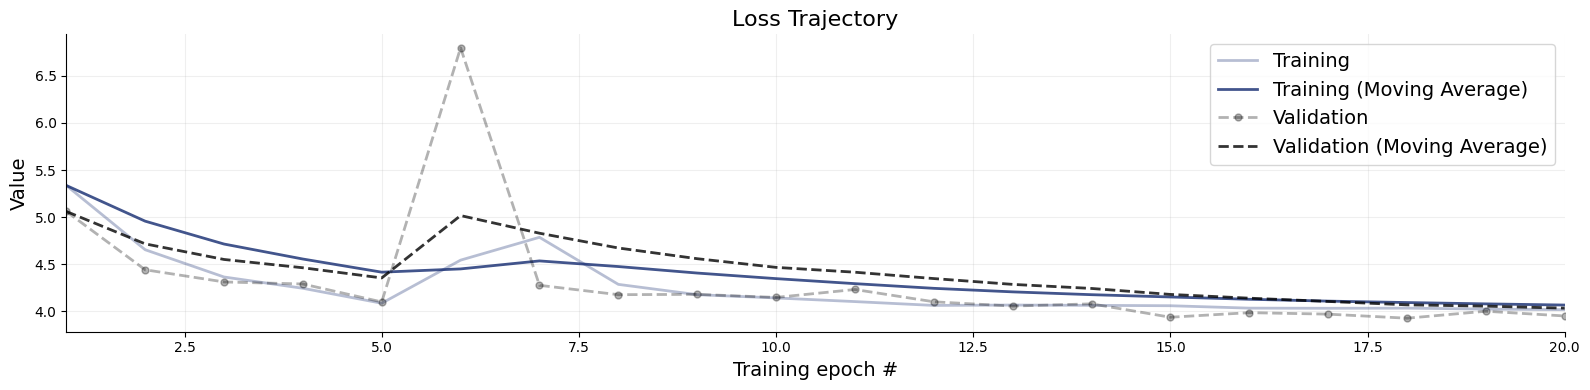

In [26]:
print(f"\nLoss History")
bf.diagnostics.plots.loss(history=history)
plt.show()